In [6]:
# Import Libraries

# vector data
import geopandas as gpd
import pandas as pd

# raster data
import xarray as xr
import rioxarray as rxr

## maps and plotting
import holoviews as hv
import hvplot.pandas

## osm
import osmnx as ox
from osmnx import features as osm

## file structure
import os
import pathlib

## earthpy
import earthpy
import earthpy.api.appeears as eaapp

In [7]:
# define project



# choose just a folder *name*, not a full path
data_dir = "arctic-greening"

# this returns a Project with a Path-like project_dir
project = earthpy.project.Project(dirname=data_dir)

print(project.project_dir, type(project.project_dir))  # should be PosixPath


/workspaces/data/arctic-greening <class 'pathlib.PosixPath'>


In [8]:
# search for juneau icefield
juneau_gdf = ox.geocode_to_gdf('Juneau Ice Sheet')
juneau_gdf

geometry   bbox_west  bbox_south  \
0  POLYGON ((-134.92667 59.12417, -134.92662 59.1... -134.926673   58.356352   

    bbox_east  bbox_north   place_id  osm_type   osm_id        lat  \
0 -133.793343   59.131667  349634157  relation  2051975  58.743988   

          lon    class     type  place_rank  importance addresstype  \
0 -134.270183  natural  glacier          22    0.106724     glacier   

               name                             display_name  
0  Juneau Ice Sheet  Juneau Ice Sheet, Alaska, United States

<Axes: >

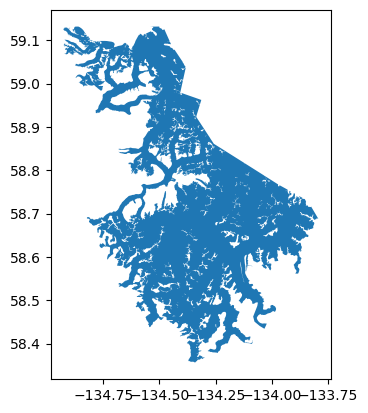

In [9]:
## make a quick plot
juneau_gdf.plot()

In [10]:
import geopandas as gpd

# read your geojson
juneau_gdf = gpd.read_file("region.geojson")

# export to shapefile folder
juneau_gdf.to_file("region_shp")   # this creates region_shp/*.shp, .dbf, .shx, .prj, etc.


/tmp/ipykernel_1569/252429267.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  juneau_gdf.to_file("region_shp")   # this creates region_shp/*.shp, .dbf, .shx, .prj, etc.


IsADirectoryError: [Errno 21] Is a directory: 'region_shp'

In [ ]:
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key="jirp_ndvi",
    project=project,
    product="MOD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="06-30",
    recurring=True,
    year_range=[2001, 2001],
    polygon=juneau_gdf,   # or whatever your study-area gdf is
)


In [ ]:
ndvi_downloader

In [ ]:
ndvi_downloader.download_files(cache=True)

Credentials found using 'env' backend.


KeyboardInterrupt: 

In [42]:
#/workspaces/data/arctic-greening/JuneauIcefield_mean_summer_NDVI_2004_2023.tif

# Adjust this to your actual filename/path
csv_path = "/workspaces/data/arctic-greening/JuneauIcefield_summer_NDVI_2004_2023.csv"

df = pd.read_csv(csv_path)

# Sometimes EE names columns differently; normalize them
df.columns = [c.lower() for c in df.columns]
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/data/arctic-greening/JuneauIcefield_summer_NDVI_2004_2023.csv'

In [43]:
# Try common column names
year_col = [c for c in df.columns if "year" in c][0]
ndvi_col = [c for c in df.columns if "ndvi" in c][0]

plt.figure(figsize=(8,4))
plt.plot(df[year_col], df[ndvi_col], marker="o")
plt.xlabel("Year")
plt.ylabel("Mean summer NDVI (June–Sept)")
plt.title("Juneau region: Mean summer NDVI, 2004–2023")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [ ]:

tif_path = "/workspaces/data/arctic-greening/JuneauIcefield_mean_summer_NDVI_2004_2023.tif"

ndvi = rxr.open_rasterio(tif_path).squeeze()  # drop band dimension
ndvi

<xarray.DataArray (y: 949, x: 1645)> Size: 12MB
[1561105 values with dtype=float64]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 13kB -135.5 -135.5 -135.5 ... -131.8 -131.8 -131.8
  * y            (y) float64 8kB 59.64 59.63 59.63 59.63 ... 57.51 57.51 57.51
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      NDVI

In [ ]:
ndvi.hvplot.image(
    cmap="Greens",
    clim=(0, 0.8),
    frame_width=500,
    title="Mean Summer NDVI (2004–2023) – Juneau Region",
    xaxis=None,
    yaxis=None,
    colorbar=True
)



:Image   [y,x]   (NDVI)

In [ ]:
import os
import glob
import imageio
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# -------------------------------
# SETTINGS
# -------------------------------
folder = "data/arctic-greening/jirp_ndvi"     # <- change this
output_gif = "ndvi_summer_timelapse.gif"
frame_duration = 0.7                      # seconds per frame
cmap = "YlGn"                             # Color map for NDVI
vmin, vmax = 0, 1                          # NDVI range for color scaling
# -------------------------------

# Find & sort all tif files
tif_files = sorted(glob.glob(os.path.join(folder, "*.tif")))

print(f"Found {len(tif_files)} tif files.")

frames = []

for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        ndvi = src.read(1).astype(float)

    # Mask invalid values
    ndvi[ndvi < -1] = np.nan

    # Plot to an image buffer
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(ndvi, cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))
    ax.axis("off")

    # Save the frame as an image in memory
    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    frames.append(frame)

# Write GIF
imageio.mimsave(output_gif, frames, duration=frame_duration)

print(f"GIF successfully saved as: {output_gif}")


Found 0 tif files.


ValueError: need at least one array to stack

In [ ]:
import os, glob

print("CWD:", os.getcwd())

folder = "/workspaces/data/arctic-greening/jirp_ndvi"   # <-- use absolute path
pattern = os.path.join(folder, "*.tif")
print("Pattern:", pattern)

tif_files = sorted(glob.glob(pattern))
print("Found", len(tif_files), "tif files.")
print("\nFirst few files:")
for f in tif_files[:5]:
    print("  ", f)


CWD: /workspaces/04-vegetation-hellafolk/notebooks
Pattern: /workspaces/data/arctic-greening/jirp_ndvi/*.tif
Found 24 tif files.

First few files:
   /workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2000.tif
   /workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2001.tif
   /workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2002.tif
   /workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2003.tif
   /workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2004.tif


In [19]:
import os
import glob
import imageio
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import re

# -------------------------------
# SETTINGS
# -------------------------------
folder = "/workspaces/data/arctic-greening/jirp_ndvi"   # <-- absolute path
output_gif = "juneau_ndvi_summer_timelapse.gif"
frame_duration = 0.7
cmap = "YlGn"
vmin, vmax = 0, 1
# -------------------------------

pattern = os.path.join(folder, "*.tif")
tif_files = sorted(glob.glob(pattern))

print(f"Pattern: {pattern}")
print(f"Found {len(tif_files)} tif files.")

if len(tif_files) == 0:
    raise FileNotFoundError(
        "No .tif files found. Check your 'folder' path (absolute path works best here)."
    )

frames = []

for tif_path in tif_files:
    # grab the year from the filename, e.g. Juneau_MODIS_summer_NDVI_2014.tif
    m = re.search(r"(\d{4})", os.path.basename(tif_path))
    year = m.group(1) if m else "Unknown year"

    with rasterio.open(tif_path) as src:
        ndvi = src.read(1).astype(float)

    ndvi[ndvi < -1] = np.nan

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(ndvi, cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))
    ax.set_title(f"Summer NDVI – {year}")
    ax.axis("off")

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    frames.append(frame)

imageio.mimsave(output_gif, frames, duration=frame_duration)
print(f"GIF successfully saved as: {output_gif}")


Pattern: /workspaces/data/arctic-greening/jirp_ndvi/*.tif
Found 24 tif files.
GIF successfully saved as: juneau_ndvi_summer_timelapse.gif


In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the region outline
gdf_3857.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

# Add basemap (Stamen removed — using CartoDB instead)
cx.add_basemap(ax, crs=gdf_3857.crs, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.tight_layout()

out_map = "juneau_ndvi_region_map.png"
plt.savefig(out_map, dpi=200, bbox_inches="tight")
plt.close(fig)

print(f"Saved region map as: {out_map}")


Saved region map as: juneau_ndvi_region_map.png


In [15]:
from PIL import Image
import imageio
import numpy as np

basemap = Image.open("juneau_ndvi_region_map.png").convert("RGBA")
gif = imageio.mimread("juneau_ndvi_summer_timelapse.gif")

frames_out = []

for frame in gif:
    frame_img = Image.fromarray(frame).convert("RGBA")

    # resize gif frame to fit on basemap
    frame_resized = frame_img.resize((int(basemap.width*0.6), int(basemap.height*0.6)))

    # create new frame
    new_frame = basemap.copy()
    x = (basemap.width - frame_resized.width) // 2
    y = (basemap.height - frame_resized.height) // 2

    new_frame.paste(frame_resized, (x, y), frame_resized)
    frames_out.append(np.array(new_frame))

# save new GIF
imageio.mimsave("ndvi_over_basemap.gif", frames_out, duration=0.7)


In [25]:
import rioxarray as rxr

tif_path = "/workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2023.tif"

ndvi = rxr.open_rasterio(tif_path, masked=True).squeeze()

ndvi


<xarray.DataArray (y: 949, x: 1645)> Size: 12MB
[1561105 values with dtype=float64]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 13kB -135.5 -135.5 -135.5 ... -131.8 -131.8 -131.8
  * y            (y) float64 8kB 59.64 59.63 59.63 59.63 ... 57.51 57.51 57.51
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      NDVI

In [26]:
ndvi_ll = ndvi.rio.reproject("EPSG:4326")
ndvi_ll


<xarray.DataArray (y: 949, x: 1645)> Size: 12MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(949, 1645))
Coordinates:
  * x            (x) float64 13kB -135.5 -135.5 -135.5 ... -131.8 -131.8 -131.8
  * y            (y) float64 8kB 59.64 59.63 59.63 59.63 ... 57.51 57.51 57.51
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      NDVI
    _FillValue:     nan

In [27]:
float(ndvi_ll.min().values), float(ndvi_ll.max().values)


(-0.2, 0.9953000000000001)

In [37]:
import hvplot.xarray  # enables .hvplot for xarray

plot = ndvi_ll.hvplot.image(
    x='x', y='y',
    geo=True,
    cmap='YlGn',
    alpha=0.6,
    tiles='EsriImagery',
    frame_width=600,
    clim=(0, 1),     # adjust if needed
    title="Summer NDVI 2023 over Alaska"
)

plot


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .Image.I :Image   [x,y]   (NDVI)

In [39]:
import panel as pn
pn.extension('bokeh')   # important!
pane = pn.pane.HoloViews(plot, width=600)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
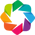

In [41]:
import holoviews as hv
hv.extension('bokeh')

plot = ndvi_ll.hvplot.image(
    x='x', y='y',
    geo=True,
    cmap='YlGn',
    alpha=0.6,
    tiles='EsriImagery',
    frame_width=600,
    clim=(0, 1),
    title="Summer NDVI 2023 over Alaska"
)

hv.save(plot, "ndvi_2023_over_alaska.html")



In [29]:
plot = ndvi_ll.hvplot.image(
    x='x', y='y',
    geo=True,
    cmap='YlGn',
    alpha=0.6,
    tiles='EsriImagery',
    frame_width=600,
    clim=(0, 1),
    title="Summer NDVI 2023 over Alaska"
)


In [34]:
import rioxarray as rxr

tif_path = "/workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2023.tif"
ndvi = rxr.open_rasterio(tif_path, masked=True).squeeze()
ndvi_ll = ndvi.rio.reproject("EPSG:4326")  # lon/lat



In [35]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

# Reproject to Web Mercator
ndvi_web = ndvi_ll.rio.reproject("EPSG:3857")

# Get extent from coords
xmin = float(ndvi_web.x.min())
xmax = float(ndvi_web.x.max())
ymin = float(ndvi_web.y.min())
ymax = float(ndvi_web.y.max())

extent = [xmin, xmax, ymin, ymax]

# Get data and sensible vmin/vmax
data = ndvi_web.values
vmin, vmax = np.nanpercentile(data, (2, 98))
print("vmin, vmax:", vmin, vmax)


vmin, vmax: -0.10955 0.8322833333333333


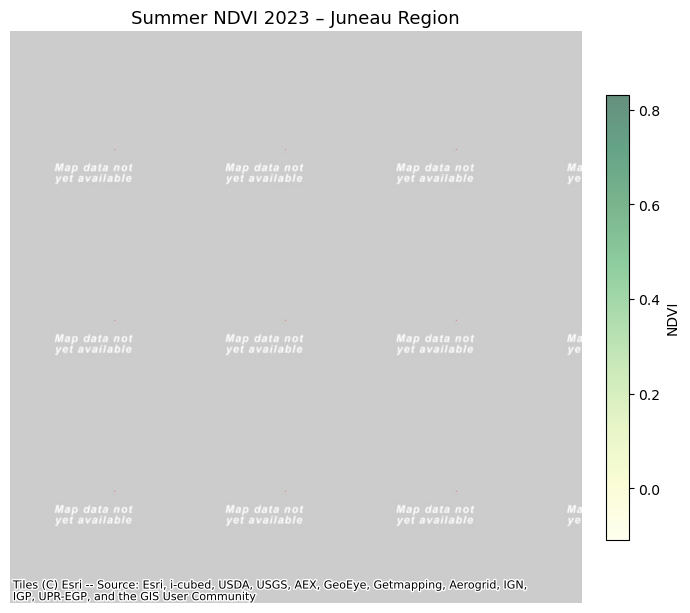

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))

# Basemap
cx.add_basemap(
    ax,
    crs="EPSG:3857",
    source=cx.providers.Esri.WorldImagery
)

# NDVI overlay
im = ax.imshow(
    data,
    extent=extent,
    cmap="YlGn",
    vmin=vmin,
    vmax=vmax,
    alpha=0.6,
    interpolation="nearest"
)

ax.set_axis_off()
ax.set_title("Summer NDVI 2023 – Juneau Region", fontsize=13)

cbar = fig.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("NDVI")

plt.tight_layout()
plt.savefig("ndvi_2023_over_alaska.png", dpi=200, bbox_inches="tight")
plt.show()


In [44]:
import pandas as pd

csv_path = "/workspaces/data/arctic-greening/jirp_ndvi/Juneau_MODIS_summer_NDVI_2000_2023.csv"

df = pd.read_csv(csv_path)
df.head()


system:index  summer_ndvi    year                                    .geo
0             0     0.202228  2000.0  {"type":"MultiPoint","coordinates":[]}
1             1     0.216107  2001.0  {"type":"MultiPoint","coordinates":[]}
2             2     0.254646  2002.0  {"type":"MultiPoint","coordinates":[]}
3             3     0.287108  2003.0  {"type":"MultiPoint","coordinates":[]}
4             4     0.292618  2004.0  {"type":"MultiPoint","coordinates":[]}

In [48]:
df = df.rename(columns={"summer_ndvi": "ndvi", "year": "year"})


In [49]:
import numpy as np

# linear regression
coef = np.polyfit(df['year'], df['ndvi'], 1)
slope, intercept = coef

# trendline values
df['trend'] = slope * df['year'] + intercept

# RMSE
rmse = np.sqrt(np.mean((df['ndvi'] - df['trend'])**2))
rmse


np.float64(0.032966989508650436)

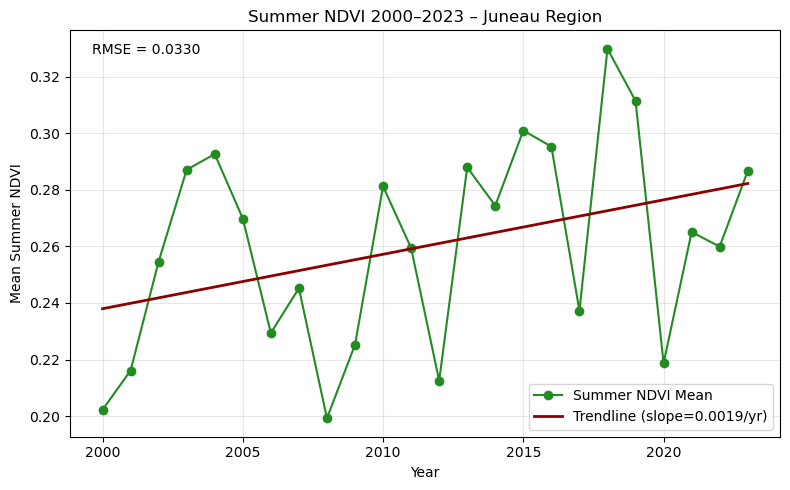

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(df['year'], df['ndvi'], marker='o', label='Summer NDVI Mean', color='forestgreen')
plt.plot(df['year'], df['trend'], color='darkred', linewidth=2,
         label=f'Trendline (slope={slope:.4f}/yr)')

plt.xlabel('Year')
plt.ylabel('Mean Summer NDVI')
plt.title('Summer NDVI 2000–2023 – Juneau Region')
plt.grid(True, alpha=0.3)
plt.legend()

plt.text(
    0.03, 0.97,
    f"RMSE = {rmse:.4f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top'
)

plt.tight_layout()
plt.savefig("ndvi_trend_2000_2023.png", dpi=200)
plt.show()


In [52]:
import hvplot.pandas  # enables .hvplot()

plot_html = df.hvplot.line(
    x='year',
    y='ndvi',
    line_width=2,
    color='forestgreen',
    marker='o',
    title="Mean Summer NDVI 2000–2023 – Southeast Alaska"
) * df.hvplot.line(
    x='year',
    y='trend',
    color='red',
    line_width=2
)

import holoviews as hv
hv.save(plot_html, "ndvi_trend_2000_2023.html")
